## Trial to model CO2 uptake with Splines

#### Based on https://bayesiancomputationbook.com/markdown/chp_05.html#modeling-co2-uptake-with-splines

In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

from patsy import bs, dmatrix

import arviz as az

import pymc3 as pm

In [2]:
np.random.seed(435)

In [4]:
plants_co2 = pd.read_csv("../data/c4_grass_co2_uptake.csv")

In [5]:
plants_co2

,Plant,conc,uptake
0,Qn1,95,16.0
1,Qn1,175,30.4
2,Qn1,250,34.8
3,Qn1,350,37.2
4,Qn1,500,35.3
...,...,...,...
79,Mc3,250,17.9
80,Mc3,350,17.9
81,Mc3,500,17.9
82,Mc3,675,18.9


In [6]:
plant_names = plants_co2.Plant.unique()

In [7]:
plant_names

array(['Qn1', 'Qn2', 'Qn3', 'Qc1', 'Qc2', 'Qc3', 'Mn1', 'Mn2', 'Mn3',
       'Mc1', 'Mc2', 'Mc3'], dtype=object)

In [8]:
co2_conc = plants_co2.conc.values[:7]

In [9]:
co2_conc

array([  95,  175,  250,  350,  500,  675, 1000])

In [10]:
co2_concs = plants_co2.conc.values

In [11]:
co2_concs

array([  95,  175,  250,  350,  500,  675, 1000,   95,  175,  250,  350,
        500,  675, 1000,   95,  175,  250,  350,  500,  675, 1000,   95,
        175,  250,  350,  500,  675, 1000,   95,  175,  250,  350,  500,
        675, 1000,   95,  175,  250,  350,  500,  675, 1000,   95,  175,
        250,  350,  500,  675, 1000,   95,  175,  250,  350,  500,  675,
       1000,   95,  175,  250,  350,  500,  675, 1000,   95,  175,  250,
        350,  500,  675, 1000,   95,  175,  250,  350,  500,  675, 1000,
         95,  175,  250,  350,  500,  675, 1000])

In [12]:
uptake = plants_co2.uptake.values

In [13]:
uptake

array([16. , 30.4, 34.8, 37.2, 35.3, 39.2, 39.7, 13.6, 27.3, 37.1, 41.8,
       40.6, 41.4, 44.3, 16.2, 32.4, 40.3, 42.1, 42.9, 43.9, 45.5, 14.2,
       24.1, 30.3, 34.6, 32.5, 35.4, 38.7,  9.3, 27.3, 35. , 38.8, 38.6,
       37.5, 42.4, 15.1, 21. , 38.1, 34. , 38.9, 39.6, 41.4, 10.6, 19.2,
       26.2, 30. , 30.9, 32.4, 35.5, 12. , 22. , 30.6, 31.8, 32.4, 31.1,
       31.5, 11.3, 19.4, 26.2, 30. , 30.9, 32.4, 35.5, 10.5, 14.9, 18.1,
       18.9, 19.5, 22.2, 21.9,  7.7, 11.4, 12.3, 13. , 12.5, 13.7, 14.4,
       10.6, 18. , 17.9, 17.9, 17.9, 18.9, 19.9])

In [14]:
index = range(12)

In [15]:
groups = len(index)

### First model - Global

In [17]:
num_knots = 2

In [18]:
knot_list = np.linspace(co2_conc[0], co2_conc[-1], num_knots+2)[1:-1]

In [19]:
bg = dmatrix(
     "bs(conc, knots=knots, degree=3, include_intercept=True) - 1",
     {"conc": co2_concs, "knots": knot_list})

In [20]:
bg

DesignMatrix with shape (84, 6)
  Columns:
    ['bs(conc, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(conc, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(conc, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(conc, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(conc, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(conc, knots=knots, degree=3, include_intercept=True)[5]']
  Terms:
    'bs(conc, knots=knots, degree=3, include_intercept=True)' (columns 0:6)
  (to view full data, use np.asarray(this_obj))

In [30]:
np.asfortranarray(bg)

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [3.96752067e-01, 5.11744442e-01, 8.83950918e-02, 3.10839883e-03,
        0.00000000e+00, 0.00000000e+00],
       [1.14924412e-01, 5.90807128e-01, 2.71660474e-01, 2.26079857e-02,
        0.00000000e+00, 0.00000000e+00],
       [3.70201666e-03, 3.77491740e-01, 5.18139199e-01, 1.00667044e-01,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.10469058e-02, 5.45745716e-01, 3.73159384e-01,
        1.00479937e-02, 0.00000000e+00],
       [0.00000000e+00, 1.15688021e-04, 2.08062123e-01, 5.95461884e-01,
        1.96360305e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [3.96752067e-01, 5.11744442e-01, 8.83950918e-02, 3.10839883e-03,
        0.00000000e+00, 

In [22]:
with pm.Model() as sp_global:
      τ = pm.HalfCauchy('τ', 1)
      β = pm.Normal("β", mu=0, sd=τ, shape=bg.shape[1])
      μg = pm.Deterministic("μg", pm.math.dot(np.asfortranarray(bg), β))
      σ = pm.HalfNormal("σ", 1)
      up = pm.Normal("up", μg, σ, observed=uptake)
      idata_sp_global = pm.sample(3000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, τ]


Sampling 2 chains for 2_000 tune and 3_000 draw iterations (4_000 + 6_000 draws total) took 34 seconds.


In [23]:
idata_sp_global

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [24]:
μsg = idata_sp_global.posterior.stack(draws=("chain", "draw"))["μg"].values.T

In [25]:
μsg

array([[12.46153269, 20.4077869 , 26.01122124, ..., 32.12445652,
        32.83710293, 33.78715801],
       [10.92341564, 21.91972603, 27.2013983 , ..., 30.75212454,
        31.69675775, 33.54254827],
       [10.76911926, 25.41749846, 31.59906074, ..., 31.06570845,
        32.27441433, 31.44426632],
       ...,
       [11.61275686, 22.46551448, 27.91182311, ..., 33.99871649,
        34.23662668, 33.93940424],
       [11.61275686, 22.46551448, 27.91182311, ..., 33.99871649,
        34.23662668, 33.93940424],
       [11.42275524, 22.47227321, 28.29997442, ..., 34.14608529,
        30.04625776, 31.42460791]])

In [26]:
μsg_mean = μsg.mean(0)

In [27]:
μsg_mean

array([11.99109507, 23.02421192, 28.19464856, 30.46554232, 31.65572618,
       31.72457631, 34.08339255, 11.99109507, 23.02421192, 28.19464856,
       30.46554232, 31.65572618, 31.72457631, 34.08339255, 11.99109507,
       23.02421192, 28.19464856, 30.46554232, 31.65572618, 31.72457631,
       34.08339255, 11.99109507, 23.02421192, 28.19464856, 30.46554232,
       31.65572618, 31.72457631, 34.08339255, 11.99109507, 23.02421192,
       28.19464856, 30.46554232, 31.65572618, 31.72457631, 34.08339255,
       11.99109507, 23.02421192, 28.19464856, 30.46554232, 31.65572618,
       31.72457631, 34.08339255, 11.99109507, 23.02421192, 28.19464856,
       30.46554232, 31.65572618, 31.72457631, 34.08339255, 11.99109507,
       23.02421192, 28.19464856, 30.46554232, 31.65572618, 31.72457631,
       34.08339255, 11.99109507, 23.02421192, 28.19464856, 30.46554232,
       31.65572618, 31.72457631, 34.08339255, 11.99109507, 23.02421192,
       28.19464856, 30.46554232, 31.65572618, 31.72457631, 34.08

/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


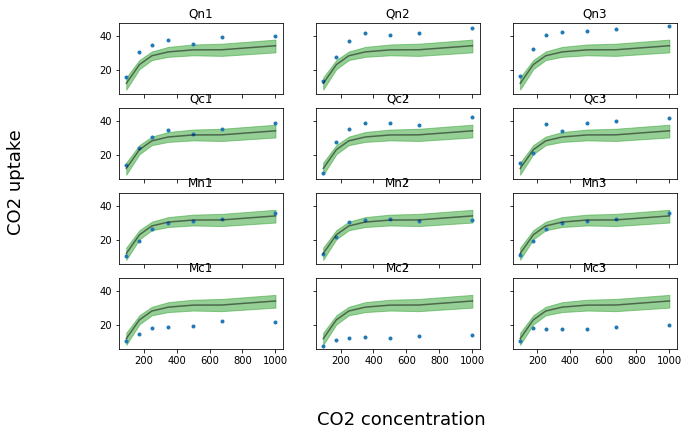

In [29]:
fig, axes = plt.subplots(4, 3, figsize=(10, 6), sharey=True, sharex=True)

for count, (idx, ax) in enumerate(zip(range(0, 84, 7), axes.ravel())):
    ax.plot(co2_conc, uptake[idx:idx+7], '.', lw=1)
    ax.plot(co2_conc, μsg_mean[idx:idx+7], "k", alpha=0.5);
    az.plot_hdi(co2_conc, μsg[:,idx:idx+7], color="C2", smooth=False, ax=ax)
    ax.set_title(plant_names[count])

fig.text(0.4, -0.05, "CO2 concentration", size=18)
fig.text(-0.03, 0.4, "CO2 uptake", size=18, rotation=90)
         
plt.savefig("../plots/sp_global.png", bbox_inches='tight')

### Second model - Individual

In [32]:
bi = dmatrix(
     "bs(conc, knots=knots, degree=3, include_intercept=True) - 1",
     {"conc": co2_conc, "knots": knot_list})

In [33]:
bi

DesignMatrix with shape (7, 6)
  Columns:
    ['bs(conc, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(conc, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(conc, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(conc, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(conc, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(conc, knots=knots, degree=3, include_intercept=True)[5]']
  Terms:
    'bs(conc, knots=knots, degree=3, include_intercept=True)' (columns 0:6)
  (to view full data, use np.asarray(this_obj))

In [36]:
with pm.Model() as sp_individual:
    τ = pm.HalfCauchy("τ", 1)
    β = pm.Normal("β", mu=0, sigma=τ, shape=(bi.shape[1], groups)) 
    μi = pm.Deterministic("μi", pm.math.dot(np.asfortranarray(bi), β))
    σ = pm.HalfNormal("σ", 1)
    up = pm.Normal("up", μi[:,index].T.ravel(), σ, observed=uptake) 
    idata_sp_individual = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, τ]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 45 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [37]:
μsi = idata_sp_individual.posterior.stack(draws=("chain", "draw"))["μi"].values.T

In [38]:
μsi_mean = μsi.mean(0)

In [40]:
μsi_mean

array([[15.96053709, 30.14947094, 35.41198786, 35.91948779, 36.25392574,
        38.46586875, 39.49532378],
       [13.16622156, 28.4119549 , 36.38431864, 40.72293   , 41.81025715,
        40.5317523 , 44.10849102],
       [16.03822383, 32.80856825, 39.79025699, 41.80984717, 43.28581339,
        43.34533092, 45.2701519 ],
       [13.87977834, 24.74949472, 30.27022538, 33.08860108, 33.84504217,
        34.54348984, 38.53900128],
       [ 9.29344516, 27.10180893, 35.18407058, 38.23353992, 38.96530602,
        37.10374309, 42.27219812],
       [13.7571487 , 25.94114014, 32.24803174, 36.01341702, 39.04666521,
        39.11312752, 41.19692711],
       [10.26592134, 20.06421999, 25.56992463, 29.26644884, 31.66737419,
        31.85422642, 35.40276243],
       [11.62080641, 23.32243796, 29.10047449, 31.90459654, 32.71810648,
        30.71700492, 31.37129734],
       [10.97670259, 20.24615063, 25.58117537, 29.297936  , 31.68222892,
        31.76794615, 35.37414696],
       [10.2907705 , 15.4812

/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


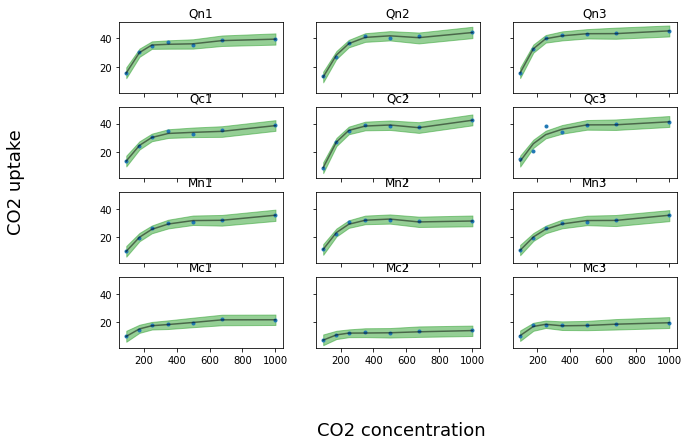

In [39]:
fig, axes = plt.subplots(4, 3, figsize=(10, 6), sharey=True, sharex=True)

for count, (idx, ax) in enumerate(zip(range(0, 84, 7), axes.ravel())):
    ax.plot(co2_conc, uptake[idx:idx+7], '.', lw=1)
    ax.plot(co2_conc, μsi_mean[index[count]], "k", alpha=0.5)
    az.plot_hdi(co2_conc, μsi[:,index[count]], color="C2", smooth=False, ax=ax)
    ax.set_title(plant_names[count])
  
fig.text(0.4, -0.075, "CO2 concentration", size=18)
fig.text(-0.03, 0.4, "CO2 uptake", size=18, rotation=90)

plt.savefig("../plots/sp_individual.png", bbox_inches='tight')

### Third model - Mix

In [41]:
with pm.Model() as sp_mix:
    τ = pm.HalfCauchy('τ', 1)
    β = pm.Normal("β", mu=0, sd=τ, shape=bg.shape[1])
    μg = pm.Deterministic("μg", pm.math.dot(np.asfortranarray(bg), β))
    βi = pm.Normal("βi", mu=0, sd=τ, shape=(bi.shape[1], groups))
    μi = pm.Deterministic("μi", pm.math.dot(np.asfortranarray(bi), βi))
    σ = pm.HalfNormal("σ", 1)
    up = pm.Normal("up", μg+μi[:,index].T.ravel(), σ, observed=uptake)
    idata_sp_mix = pm.sample(3000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, βi, β, τ]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 70 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [42]:
μsg = idata_sp_mix.posterior.stack(draws=("chain", "draw"))["μg"].values.T

In [43]:
μsg_mean = μsg.mean(0)

In [44]:
μsi = idata_sp_mix.posterior.stack(draws=("chain", "draw"))["μi"].values.T

In [45]:
μsi_mean = μsi.mean(0)

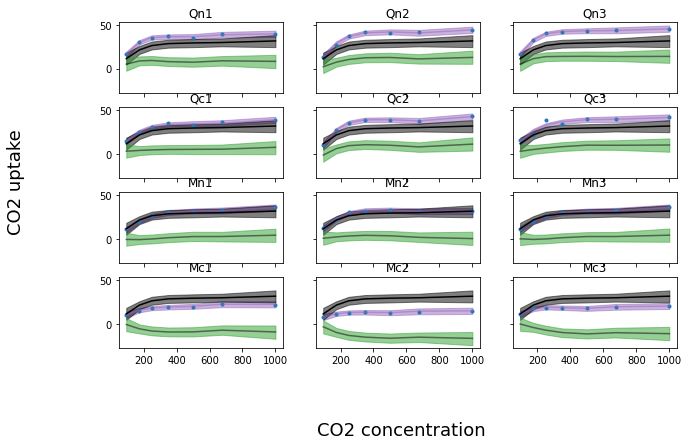

In [47]:
fig, axes = plt.subplots(4, 3, figsize=(10, 6), sharey=True, sharex=True)

for count, (idx, ax) in enumerate(zip(range(0, 84, 7), axes.ravel())):
    ax.plot(co2_conc, uptake[idx:idx+7], '.', lw=1)
    ax.plot(co2_conc, μsg_mean[idx:idx+7]+μsi_mean[index[count]], "C4", alpha=0.5)
    az.plot_hdi(co2_conc, μsg[:,idx:idx+7]+μsi[:,index[count]], color="C4", smooth=False,ax=ax)
    ax.plot(co2_conc, μsg_mean[idx:idx+7], "k")
    az.plot_hdi(co2_conc, μsg[:,idx:idx+7], color="k", smooth=False,ax=ax)
    ax.plot(co2_conc, μsi_mean[index[count]], "k", alpha=0.5)
    az.plot_hdi(co2_conc, μsi[:,index[count]], color="C2", smooth=False,ax=ax)
    ax.set_title(plant_names[count])
    
fig.text(0.4, -0.075, "CO2 concentration", size=18)
fig.text(-0.03, 0.4, "CO2 uptake", size=18, rotation=90)

plt.savefig("../plots/sp_mix_decomposed.png", bbox_inches='tight')

### Model comparison

In [48]:
cmp = az.compare({"sp_global":idata_sp_global,
                  "sp_individual":idata_sp_individual,
                  "sp_mix":idata_sp_mix})

/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a n

In [49]:
cmp

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
sp_mix,0,-214.390651,54.957430,0.000000,0.959488,12.547796,0.000000,True,log
sp_individual,1,-223.137978,57.472665,8.747327,0.000000,10.963623,2.417313,True,log
sp_global,2,-306.949026,9.146588,92.558376,0.040512,9.445861,16.076176,False,log


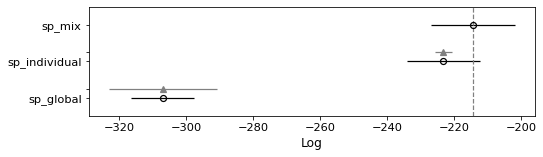

In [50]:
az.plot_compare(cmp, insample_dev=False, figsize=(8, 2))
plt.savefig("../plots/sp_compare.png")